In [248]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, SimpleRNN, Masking
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model, pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

from IPython.display import HTML

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, accuracy_score,mean_absolute_error
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression

from src.data import *
from src.utils import *
from src.models import *
from src.layers.Bottleneck import *

# The Task

 As a well-known data scientist, you were asked for help by a company producing candies. Some of their products are plagued with different types of defects. The whole manufacture is equipped with sensors so there are several time series describing the process of producing candies. They would like to achieve two goals:


1. Have a predictive model which will tell them if a given candy has a defect and which ones

2. Perform a root cause analysis - they would like to know what patterns in the data are related to defects



Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

# Data Creation

- For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 
- One candy can have zero, one or more defects at once.
- Patterns are of different length
- There is one defect related to a pattern occurring at two sensors simultaneously



In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)

[False False False False  True]


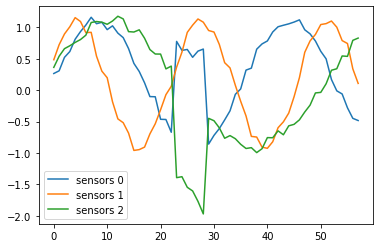

[False False False  True  True]


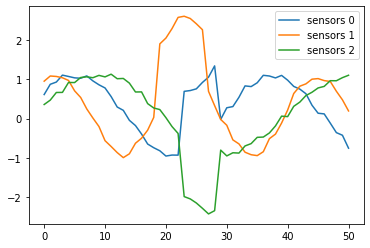

[False False False False False]


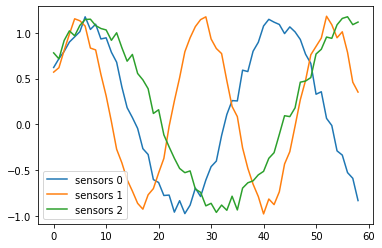

[ True False False False  True]


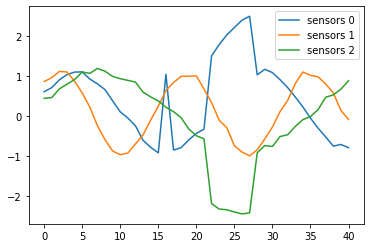

[False  True False False False]


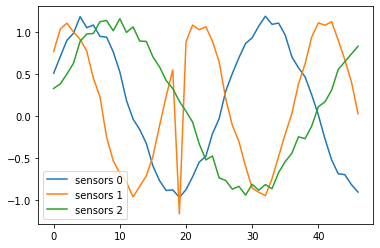

In [5]:
plot_sensors(xl,yl)

# Preprocess and split data

In [6]:
x_pad = pad_sequences(xl,dtype='float64',value=np.nan)
y = np.array(yl).astype(np.uint8)

In [7]:
samples, timesteps, features = x_pad.shape
x_pad.shape

(50000, 59, 3)

In [8]:
_, labels = y.shape
y.shape

(50000, 5)

In [9]:
scaler = MinMaxScaler()
x_pad = scaler.fit_transform(x_pad.reshape(-1, x_pad.shape[-1])).reshape(x_pad.shape)
X = np.nan_to_num(x_pad,nan=-2)

In [10]:
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

N = len(x_pad)
train_size,val_size,test_size = int(N*train_frac),int(N*val_frac),int(N*test_frac)
data_idx = list(range(N))
np.random.shuffle(data_idx)
train_idx,test_idx,val_idx = data_idx[:train_size],data_idx[-test_size:],data_idx[train_size+1:train_size+val_size]
X_train,y_train = X[train_idx],y[train_idx]
X_test,y_test = X[test_idx],y[test_idx]
X_val,y_val = X[val_idx],y[val_idx]

# The Model

In [11]:
model = create_encoder(timesteps,features,labels,lr=0.001)
# with strat.scope():
#     model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 59, 3)             0         
                                                                 
 gru (GRU)                   (None, 59, 64)            13248     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)    

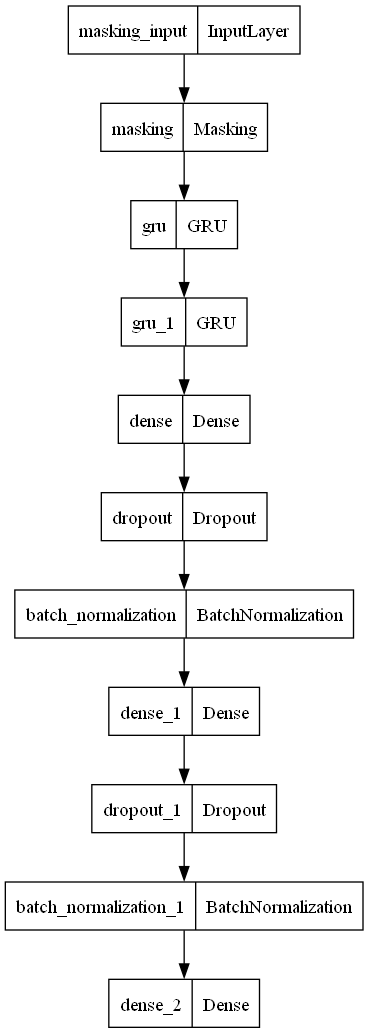

In [12]:
plot_model(model)

In [13]:
def learning_schedule(epoch,lr):
    return lr if epoch < 5 else lr * tf.math.exp(-0.1)

In [14]:
early = EarlyStopping(patience=3, restore_best_weights=True)
scheduler = LearningRateScheduler(learning_schedule)
history = model.fit(X_train,y_train, validation_data=(X_val,y_val), batch_size=64, epochs=30, callbacks=[early,scheduler])

Epoch 1/30


625/625 [==============================] - 26s 33ms/step - loss: 0.5678 - binary_accuracy: 0.7089 - val_loss: 0.4359 - val_binary_accuracy: 0.8032 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 18s 29ms/step - loss: 0.3754 - binary_accuracy: 0.8355 - val_loss: 0.3110 - val_binary_accuracy: 0.8781 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 19s 30ms/step - loss: 0.2953 - binary_accuracy: 0.8761 - val_loss: 1.5386 - val_binary_accuracy: 0.7840 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 18s 29ms/step - loss: 0.2586 - binary_accuracy: 0.8925 - val_loss: 0.2273 - val_binary_accuracy: 0.9068 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 18s 30ms/step - loss: 0.2450 - binary_accuracy: 0.8979 - val_loss: 0.2221 - val_binary_accuracy: 0.9045 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 19s 31ms/step - loss: 0.2263 - binary_accuracy: 0.9056 - val_loss: 0.2408 - val_binary_ac

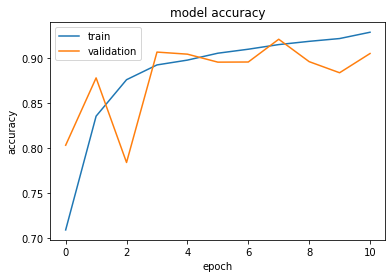

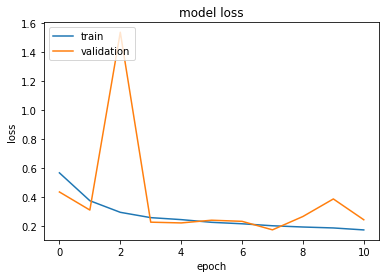

In [15]:
visualize(history)

In [16]:
y_pred = model.predict(X_test)

157/157 [==============================] - 4s 10ms/step


In [17]:
model.evaluate(X_test,y_test)

157/157 [==============================] - 2s 10ms/step - loss: 0.1723 - binary_accuracy: 0.9237


[0.17230424284934998, 0.9237199425697327]

In [18]:
y_pred

array([[1.59903392e-01, 4.79454249e-02, 2.52448738e-01, 3.90568236e-03,
        1.00000000e+00],
       [9.90172386e-01, 6.06229864e-02, 2.75198430e-01, 5.30435995e-04,
        9.97658470e-04],
       [1.09744910e-03, 2.55269948e-02, 2.71057427e-01, 8.33067927e-04,
        8.62074885e-05],
       ...,
       [2.78409780e-03, 1.90048933e-01, 2.66767919e-01, 9.99996185e-01,
        3.77097371e-04],
       [4.02441889e-04, 1.99447349e-01, 2.54216850e-01, 9.99999106e-01,
        1.17647520e-04],
       [1.10629216e-01, 6.69124946e-02, 2.42074981e-01, 1.39856245e-03,
        1.00000000e+00]], dtype=float32)

In [19]:
y_thresh = (y_pred > 0.5).astype(np.uint8)
y_thresh

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [20]:
y_test

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1]], dtype=uint8)

In [21]:
[accuracy_score(y_test[:,j],y_thresh[:,j]) for j in range(labels)]

[0.933, 0.9306, 0.755, 1.0, 1.0]

# Root Cause Analysis

In [215]:
cpus = tf.config.list_logical_devices('CPU')
strategy = tf.distribute.MirroredStrategy(cpus)
autoencoder = None

with strategy.scope():
	adam = Adam(learning_rate=0.001)
	autoencoder = Sequential()

	autoencoder.add(Masking(mask_value=-2.0,input_shape=(timesteps,features)))
	autoencoder.add(GRU(64,input_shape=(None,features),return_sequences=True))
	autoencoder.add(GRU(32,return_sequences=True))
	autoencoder.add(Bottleneck(GRU(labels,activation='sigmoid'),timesteps))
	autoencoder.add(GRU(32,return_sequences=True))
	autoencoder.add(GRU(64,return_sequences=True))
	autoencoder.add(TimeDistributed(Dense(features)))

	autoencoder.build(input_shape=(None,features))
	autoencoder.compile(optimizer=adam, loss='mae', metrics=['mse'])

autoencoder.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_21 (Masking)        (None, 59, 3)             0         
                                                                 
 gru_59 (GRU)                (None, 59, 64)            13248     
                                                                 
 gru_60 (GRU)                (None, 59, 32)            9408      
                                                                 
 bottleneck_3 (Bottleneck)   (None, 59, 5)             585       
                                                                 
 gru_62 (GRU)                (None, 59, 32)            3744      
                                                                 
 gru_63 (GRU)                (None, 59, 64)            18816     
                 

In [216]:
for i, l in enumerate(autoencoder.layers):
    print(f'layer {i}: {l}')
    print(f'has input mask: {l.input_mask}')
    print(f'has output mask: {l.output_mask}')


layer 0: <keras.src.layers.core.masking.Masking object at 0x000001B58E637D90>
has input mask: None
has output mask: KerasTensor(type_spec=TensorSpec(shape=(None, 59), dtype=tf.bool, name=None), name='masking_21/Squeeze:0')
layer 1: <keras.src.layers.rnn.gru.GRU object at 0x000001B5412C70D0>
has input mask: KerasTensor(type_spec=TensorSpec(shape=(None, 59), dtype=tf.bool, name=None), name='masking_21/Squeeze:0')
has output mask: KerasTensor(type_spec=TensorSpec(shape=(None, 59), dtype=tf.bool, name=None), name='Placeholder_2:0')
layer 2: <keras.src.layers.rnn.gru.GRU object at 0x000001B58E8A6100>
has input mask: KerasTensor(type_spec=TensorSpec(shape=(None, 59), dtype=tf.bool, name=None), name='Placeholder_2:0')
has output mask: KerasTensor(type_spec=TensorSpec(shape=(None, 59), dtype=tf.bool, name=None), name='Placeholder_2:0')
layer 3: <__main__.Bottleneck object at 0x000001B552366A00>
has input mask: KerasTensor(type_spec=TensorSpec(shape=(None, 59), dtype=tf.bool, name=None), name='

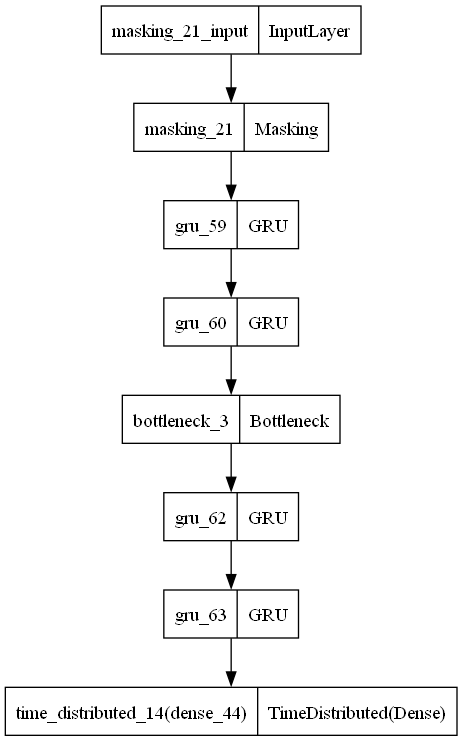

In [217]:
plot_model(autoencoder)

In [218]:
history = autoencoder.fit(X_train,X_train, validation_data=[X_val,X_val], batch_size=32, epochs=2, callbacks=[scheduler])

Epoch 1/2
1250/1250 [==============================] - 109s 77ms/step - loss: 0.0608 - mse: 0.0110 - val_loss: 0.0402 - val_mse: 0.0053 - lr: 0.0010
Epoch 2/2
1250/1250 [==============================] - 92s 73ms/step - loss: 0.0392 - mse: 0.0051 - val_loss: 0.0391 - val_mse: 0.0052 - lr: 0.0010


In [219]:
X_pred = autoencoder.predict(X_test)

157/157 [==============================] - 10s 30ms/step


In [230]:
autoencoder.evaluate(X_test,X_test)

157/157 [==============================] - 5s 28ms/step - loss: 0.0386 - mse: 0.0050


[0.038634032011032104, 0.005048488266766071]

In [245]:
masking_layer = Masking(mask_value=-2)(X_test)
mask = masking_layer._keras_mask
X_pred[np.logical_not(mask)] = -2

In [246]:
type(history)

keras.src.callbacks.History

[0 0 0 0 1]


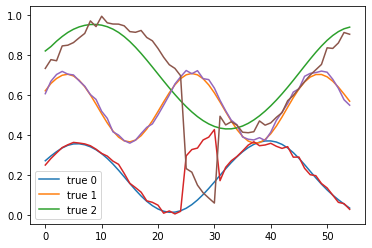

[1 0 0 0 0]


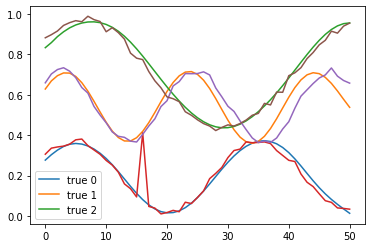

[0 0 0 0 0]


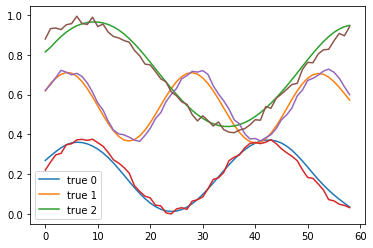

[1 0 0 1 1]


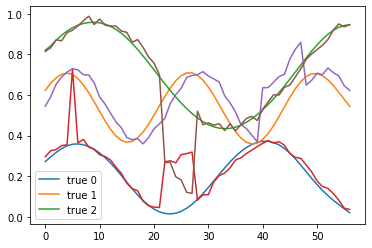

[0 1 0 0 0]


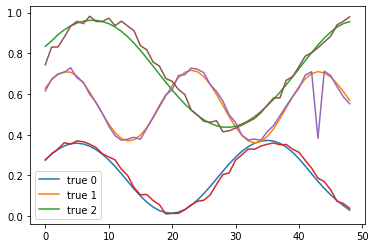

In [244]:
compare_sensors(X_pred,X_test,y_test,mask)